In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import tqdm

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#defining stopwords
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import casual_tokenize

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.naive_bayes import GaussianNB, MultinomialNB

In [2]:
data = pd.read_json('C:/Users/Lenovo/Documents/ILKOM SEM 1/DATA SCIENCE/News_Category_Dataset_v2.json', lines=True)
data.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
#DATA EXPLORATION
# Dataset
print(data.shape)
data.info()

(200853, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [4]:
kategori = data.groupby('category').count()
kategori

,headline,authors,link,short_description,date
category,,,,,
ARTS,1509,1509,1509,1509,1509
ARTS & CULTURE,1339,1339,1339,1339,1339
BLACK VOICES,4528,4528,4528,4528,4528
BUSINESS,5937,5937,5937,5937,5937
COLLEGE,1144,1144,1144,1144,1144
COMEDY,5175,5175,5175,5175,5175
CRIME,3405,3405,3405,3405,3405
CULTURE & ARTS,1030,1030,1030,1030,1030
DIVORCE,3426,3426,3426,3426,3426


In [5]:
data['category'].nunique()

41

In [6]:
#Mengambil kolom yang akan di klasifikasi
df = data.drop(columns=['authors','link','date'])
df.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


In [7]:
#DATA PRE PROCESSING
# Menghapus data jika terdapat data kosong pada kolom short_description, headline, dan category.
print(len(df[df['headline'] == ""]))
print(len(df[df['short_description'] == ""]))
print(len(df[df['category'] == ""]))

6
19712
0


In [8]:
df.drop(df[(df['headline'] == '' )].index, inplace=True)
df.drop(df[(df['short_description'] == '' )].index, inplace=True)

In [9]:
print(len(df[df['headline'] == ""]))
print(len(df[df['short_description'] == ""]))

0
0


In [10]:
#Menghilangkan duplikat data
df = df.copy()
df.duplicated().sum()

377

In [11]:
df.drop_duplicates(keep='last', inplace=True) 
df.duplicated(subset=['short_description','headline']).sum()
df.drop_duplicates(subset=['short_description','headline'],keep='last',inplace=True)

In [12]:
from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True) 

In [13]:
df['desc'] = df['headline'].astype(str) + "-" + df['short_description']
df.drop(columns =['headline','short_description'],axis = 1, inplace=True)
df.astype(str)
df.head()

,category,desc
0,ARTS,10 Ways to Increase Your Creativity-Creativity...
1,POLITICS,"Putin, Trump And The Rise Of The Deep State-Th..."
2,BLACK VOICES,What's Next For The Obamas? Michelle Promises ...
3,BUSINESS,Another Big Company Steps Up To Improve Matern...
4,COMEDY,"What To Do When Your Intern Dies, But There's ..."


In [14]:
df.describe()

,category,desc
count,180753,180753
unique,41,180753
top,POLITICS,College Photos Of Martin Luther King Jr. Show ...
freq,29562,1


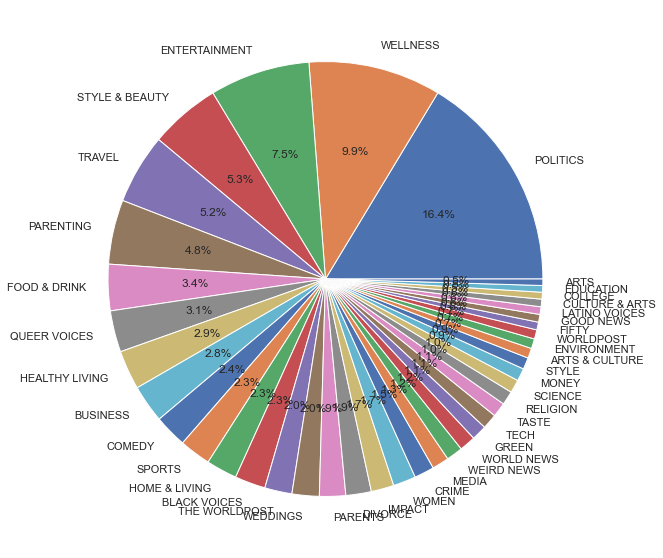

In [14]:
fig = plt.figure(figsize=(10,10))
plt.pie(df['category'].value_counts().values, 
        labels=df['category'].value_counts().index,
        autopct='%1.1f%%');

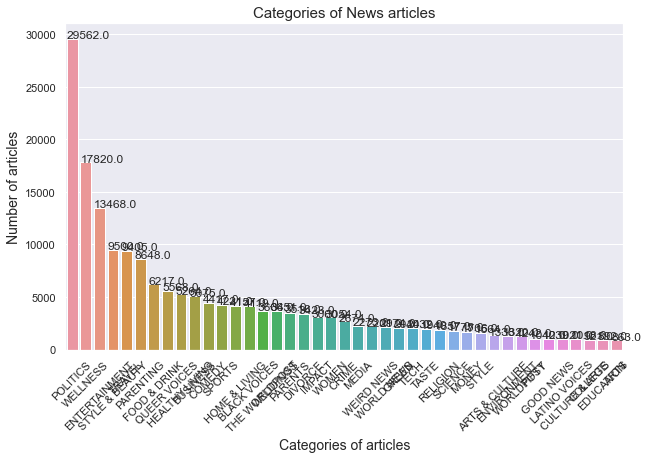

In [15]:
cat_df = pd.DataFrame(df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.news_classes)[:41], np.array(cat_df.numcat)[:41])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

In [16]:
#Menyeimbangkan Kategori
categories = df['category'].value_counts().index

def groupper(grouplist,name):
    for ele in categories:
        if ele in grouplist:
            df.loc[df['category'] == ele, 'category'] = name

In [17]:
groupper( grouplist= ['WELLNESS', 'HEALTHY LIVING'] , name =  'WELLNESS')
groupper(grouplist= ['HOME & LIVING','STYLE & BEAUTY' ,'STYLE', 'WOMEN'] , name = 'LIFESTYLE')
groupper( grouplist= ['PARENTING', 'PARENTS' ,'DIVORCE'] , name =  'PARENTING')
groupper(grouplist= ['EDUCATION' ,'COLLEGE', 'TECH', 'SCIENCE'] , name = 'EDUCATION, SCIENCE, AND TECH')
groupper( grouplist= ['SPORTS','ENTERTAINMENT' , 'COMEDY','WEIRD NEWS','WEDDINGS'] , name =  'SPORTS AND ENTERTAINMENT')
groupper( grouplist= ['TRAVEL', 'ARTS & CULTURE','CULTURE & ARTS','FOOD & DRINK', 'TASTE', 'ARTS'] , name =  'TRAVEL-TOURISM & ART-CULTURE')
groupper( grouplist= ['QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name =  'VOICES')
groupper( grouplist= ['BUSINESS' ,  'MONEY'] , name =  'ECONOMICS')
groupper( grouplist= ['THE WORLDPOST' , 'WORLDPOST' , 'WORLD NEWS', 'GOOD NEWS'] , name =  'WORLDNEWS')
groupper( grouplist= ['ENVIRONMENT' ,'GREEN'] , name =  'ENVIRONMENT')
groupper( grouplist= ['FIFTY' , 'IMPACT' ,'CRIME','RELIGION','MEDIA'] , name =  'GENERAL')

In [18]:
print("We have a total of {} categories now".format(df['category'].nunique()))
df['category'].value_counts()

We have a total of 12 categories now


POLITICS                        29562
SPORTS AND ENTERTAINMENT        27966
WELLNESS                        23084
TRAVEL-TOURISM & ART-CULTURE    20781
LIFESTYLE                       18275
PARENTING                       15587
GENERAL                         10906
VOICES                          10708
WORLDNEWS                        8119
ECONOMICS                        6781
EDUCATION, SCIENCE, AND TECH     5620
ENVIRONMENT                      3364
Name: category, dtype: int64

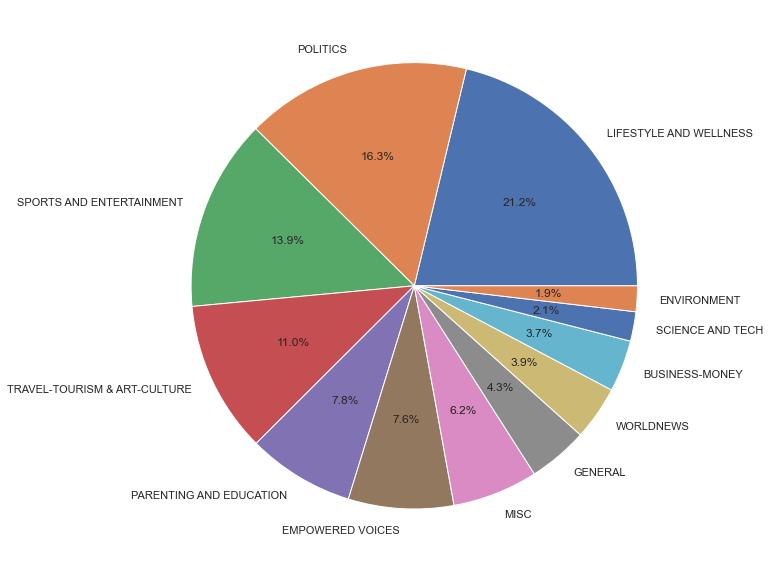

In [20]:
fig = plt.figure(figsize=(10,20))
plt.pie(df['category'].value_counts().values, 
        labels=df['category'].value_counts().index,
        autopct='%1.1f%%');

In [32]:
from nltk.corpus import stopwords

In [58]:
# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
class DataPreparation:
    def __init__(self, data, column='desc'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        
        return self.df
    def tokenize(self):
        self.df['clean_desc'] = self.df[self.column].apply(nltk.word_tokenize)
        print("Tokenization is done.")
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        
        self.df['clean_desc'] = self.df['clean_desc'].apply(rem_stopword)
        print("Remove stopwords done.")
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
            :numbers: 0-9
            :punctuation: All english punctuations
            :special characters: All english special characters
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_desc'] = self.df['clean_desc'].apply(rem_special_chars)
        print("Removed non english characters is done.")
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        self.df['clean_desc'] = self.df['clean_desc'].apply(on_word_lemma)
        print("Lemmatization on the words.")

In [20]:
data_prep = DataPreparation(df)

cleanse_df = data_prep.preprocess()

Tokenization is done.
Remove stopwords done.
Removed non english characters is done.
Lemmatization on the words.


In [45]:
df.head()

,category,desc,clean_desc
0,GENERAL,Joan Rivers Explores the Dark Side of Adoption...,"[nation, learn, death, beloved, comic, icon, r..."
1,ENVIRONMENT,Winterizing Home Tips: Energy-Saving Ideas For...,"[winter, season, drag, energy, bill, energy, e..."
2,SPORTS AND ENTERTAINMENT,Dog's Cone Of Shame Halloween Costume Makes Th...,"[bearmanatee, dog, may, cone, shame, go, stop,..."
3,"EDUCATION, SCIENCE, AND TECH",The Bitcoin Hoax-We should hardly be surprised...,"[hardly, surprise, wild, speculative, ride—tha..."
4,"EDUCATION, SCIENCE, AND TECH",A MOOC By Any Other Name-MOOCS are forcing us ...,"[force, us, think, online, education, already,..."


In [60]:
!pip install gensim

In [21]:
from gensim.models import Word2Vec 

In [65]:
model = Word2Vec(df['clean_desc'], min_count=1)   
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors)) 

In [22]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [70]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'activation': ['tanh', 'relu']}
}

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(df['clean_desc'], cleanse_df['category'], test_size=0.2, shuffle=True)

In [26]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [76]:
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    # Fitting the data
    clf.fit(X_train, y_train)
    
    y_preds = clf.predict(X_valid)
    
    
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                     precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                      f1_score(y_valid, y_preds, average='macro')))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py", line 210, in fit
    X, y = self._validate_data(X, y)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 73, in inner_f
    return f(**kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-p

ValueError: setting an array element with a sequence.

In [27]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec
def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels

def algorithm_stack(models, params, X_train, X_test, y_train, y_test):
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Keys do not match')
        
    for key in models.keys():
        model = models[key]
        param = params[key]
        
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        
        y_pred = gs.predict(X_test)
        
        print(key, ":")
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_test, y_pred),
                                                                                          precision_score(y_test, y_pred, average='macro'),
                                                                                     recall_score(y_test, y_pred, average='macro'),
                                                                                     f1_score(y_test, y_pred, average='macro')))
    return
                                                                                          


In [28]:
# Encode the class labels
y_enc_train, labels = label_encoding(df['category'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(df['desc'], y_enc_train, test_size=0.2, shuffle=True)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}
# Modified parameters
clf_params = {
    'Naive Bayes': {'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [1, 2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu']}
}

Vectorization is completed.
(144602, 78120) (36151, 78120)


In [80]:
y_train

array([ 6, 11,  7, ...,  6, 10,  3])

In [ ]:
algorithm_stack(clf_models, clf_params, X_train_vec, X_valid_vec, y_train, y_test)

Naive Bayes :
Accuracy: 0.664 	Precision: 0.688 	Recall: 0.534 	F1-Score: 0.561

